In [23]:
# pip install "xarray[complete]" netcdf4 h5netcdf zarr

In [24]:
# pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Import libraries
import os
import s3fs
import numpy as np
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt

from PIL import Image
import os
import glob

In [2]:
# replace ./content with 

output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Create the folder names list
folder_names = ["GOES", "JPG", "Animation"]

# Iterate through the folder names and create the folders
for folder_name in folder_names:
    folder_path = os.path.join(output_dir, folder_name)
    # Check if the folder doesn't exist, then create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
    else:
        print(f"Folder {folder_path} already exists")

GOES_dir = os.path.join(output_dir, 'GOES')
JPG_dir = os.path.join(output_dir, 'JPG')
Animation_dir = os.path.join(output_dir, 'Animation')

Folder ./output/GOES already exists
Folder ./output/JPG already exists
Folder ./output/Animation already exists


In [4]:
# Define the bucket and product
bucket = 'noaa-goes18' # other options: 'noaa-goes16', 'noaa-goes17', 'noaa-goes18'
product = 'ABI-L1b-RadC'

# Define the hour, day of the year and year
hour = 22
doy = 31    # day of the year
year = 2025

In [5]:
# Connect to the S3 file system
fs = s3fs.S3FileSystem(anon=True)

# Define the master URL
master_url = f'{bucket}/{product}/{year}/{doy:03.0f}/{hour:02.0f}/'
print(master_url)

# Get the URLs for different channels
urls = fs.ls(master_url)

noaa-goes18/ABI-L1b-RadC/2025/031/22/


In [6]:
urls_C01 = []
urls_C02 = []
urls_C03 = []

urls_C01 = [url for url in urls if url.endswith('.nc') and 'C01' in url]
urls_C02 = [url for url in urls if url.endswith('.nc') and 'C02' in url]
urls_C03 = [url for url in urls if url.endswith('.nc') and 'C03' in url]

# Sort the URLs
urls_C01.sort()
urls_C02.sort()
urls_C03.sort()

In [7]:
# Define the paths for different channels
path_C01 = os.path.join(GOES_dir,urls_C01[0].split("/")[-1])
path_C02 = os.path.join(GOES_dir,urls_C02[0].split("/")[-1])
path_C03 = os.path.join(GOES_dir,urls_C03[0].split("/")[-1])

# Download the data for different channels
print("Starting...")

fs.download(urls_C01[0], path_C01)
print(f"{urls_C01[0]} has been downloaded")

fs.download(urls_C02[0], path_C02)
print(f"{urls_C02[0]} has been downloaded")

fs.download(urls_C03[0], path_C03)
print(f"{urls_C03[0]} has been downloaded")

Starting...


In [8]:
# Open the downloaded data using xarray
Blue = xr.open_dataset(path_C01)
Red = xr.open_dataset(path_C02)
Nir = xr.open_dataset(path_C03)

# Extract the data arrays
Blue_array = Blue.Rad.data
Red_array = Red.Rad.data
Nir_array = Nir.Rad.data

In [9]:
# Calculate the reflectance values
Blue_reflec = Blue.kappa0.data * Blue_array
Red_reflec = Red.kappa0.data * Red_array
Nir_reflec = Nir.kappa0.data * Nir_array

# Clip the reflectance values between 0 and 1
Blue_reflec_clip = np.clip(Blue_reflec, 0, 1)
Red_reflec_clip = np.clip(Red_reflec, 0, 1)
Nir_reflec_clip = np.clip(Nir_reflec, 0, 1)

In [10]:
# Apply gamma correction
gamma = 3
Blue_gamma = np.power(Blue_reflec_clip, 1/gamma)
Red_gamma = np.power(Red_reflec_clip, 1/gamma)
Nir_gamma = np.power(Nir_reflec_clip, 1/gamma)

In [11]:
# Define a function to downsample the array
def downsample_array(input_array):
    # Calculate the dimensions of the output array
    output_rows = input_array.shape[0] // 2
    output_cols = input_array.shape[1] // 2

    # Reshape the input array into a 4D array, then compute the mean along the last two dimensions
    reshaped_array = input_array.reshape(output_rows, 2, output_cols, 2)
    output_array = reshaped_array.mean(axis=(1, 3))

    return output_array

# Downsample the Red_gamma array
Red_gamma_reshaped = downsample_array(Red_gamma)

In [12]:
# Calculate the Green channel using the Red, Blue and Nir channels
# // Bah, M. K., Gunshor, M. M., &amp; Schmit, T. J. (2018). Generation of GOES-16 true color imagery without a green band. Earth and Space Science, 5, 549–558. https://doi.org/10.1029/2018EA000379
G_gamma = 0.45 * Red_gamma_reshaped + 0.1 * Nir_gamma + 0.45 * Blue_gamma

# Combine the Red, Green and Blue channels to create the RGB array for the true color image
RGB = np.dstack([Red_gamma_reshaped, G_gamma, Blue_gamma])

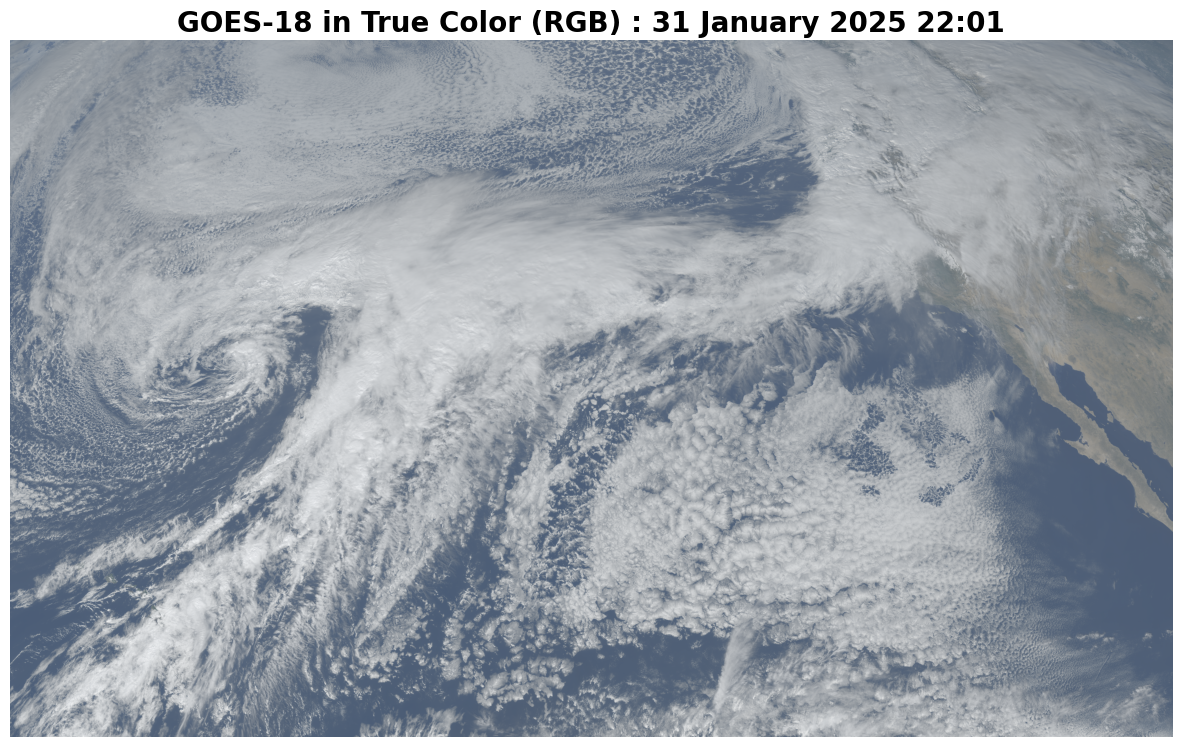

In [13]:
# Plot the true color image
fig = plt.figure(figsize=(15, 12))

plt.imshow(RGB)

# Get the scan start time and format it
scan_start = datetime.strptime(Blue.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
Time = scan_start.strftime('%d %B %Y %H:%M')

# Add title and axis labels to the plot
plt.title(f'GOES-18 in True Color (RGB) : {Time}', fontweight='bold', fontsize=20)
plt.axis('off')

# Show the plot
plt.show()

## TIMELAPSE

In [28]:
# Define the bucket and product
bucket = 'noaa-goes18' # other options: 'noaa-goes16', 'noaa-goes17', 'noaa-goes18'
product = 'ABI-L1b-RadC'

# Define the hour, day of the year and year
hours = range(16,24)
doy = 31    # day of the year
year = 2025

In [29]:
# Connect to the S3 file system
fs = s3fs.S3FileSystem(anon=True)

urls_C01 = []
urls_C02 = []
urls_C03 = []

for hour in hours:
  # Define the master URL
  master_url = f'{bucket}/{product}/{year}/{doy:03.0f}/{hour:02.0f}/'
  print(master_url)

  # Get the URLs for different channels
  urls = fs.ls(master_url)

  urls_C01_hour = [url for url in urls if url.endswith('.nc') and 'C01' in url]
  urls_C02_hour = [url for url in urls if url.endswith('.nc') and 'C02' in url]
  urls_C03_hour = [url for url in urls if url.endswith('.nc') and 'C03' in url]

  urls_C01.extend(urls_C01_hour)
  urls_C02.extend(urls_C02_hour)
  urls_C03.extend(urls_C03_hour)

# Sort the URLs
urls_C01.sort()
urls_C02.sort()
urls_C03.sort()

noaa-goes18/ABI-L1b-RadC/2025/031/16/
noaa-goes18/ABI-L1b-RadC/2025/031/17/
noaa-goes18/ABI-L1b-RadC/2025/031/18/
noaa-goes18/ABI-L1b-RadC/2025/031/19/
noaa-goes18/ABI-L1b-RadC/2025/031/20/
noaa-goes18/ABI-L1b-RadC/2025/031/21/
noaa-goes18/ABI-L1b-RadC/2025/031/22/
noaa-goes18/ABI-L1b-RadC/2025/031/23/


In [ ]:
for i in range(0,len(urls_C01),4):
  path_C01 = os.path.join(GOES_dir,urls_C01[i].split("/")[-1])
  path_C02 = os.path.join(GOES_dir,urls_C02[i].split("/")[-1])
  path_C03 = os.path.join(GOES_dir,urls_C03[i].split("/")[-1])

  print("Starting...")
  fs.download(urls_C01[i], path_C01)
  print(f"{urls_C01[i]} has been downloaded")
  fs.download(urls_C02[i], path_C02)
  print(f"{urls_C02[i]} has been downloaded")
  fs.download(urls_C03[i], path_C03)
  print(f"{urls_C03[i]} has been downloaded")

Starting...
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C01_G18_s20250311601188_e20250311603561_c20250311603597.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C02_G18_s20250311601188_e20250311603561_c20250311603587.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C03_G18_s20250311601188_e20250311603561_c20250311604009.nc has been downloaded
Starting...
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C01_G18_s20250311621188_e20250311623561_c20250311623596.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C02_G18_s20250311621188_e20250311623561_c20250311623588.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C03_G18_s20250311621188_e20250311623561_c20250311624006.nc has been downloaded
Starting...
noaa-goes18/ABI-L1b-RadC/2025/031/16/OR_ABI-L1b-RadC-M6C01_G18_s20250311641188_e20250311643561_c20250311644004.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2

In [ ]:
# Define a function to downsample the array
def downsample_array(input_array):
    # Calculate the dimensions of the output array
    output_rows = input_array.shape[0] // 2
    output_cols = input_array.shape[1] // 2

    # Reshape the input array into a 4D array, then compute the mean along the last two dimensions
    reshaped_array = input_array.reshape(output_rows, 2, output_cols, 2)
    output_array = reshaped_array.mean(axis=(1, 3))

    return output_array

def plot_GOES(path_C01,path_C02,path_C03,jpg_folder):
  # Open the downloaded data using xarray
  Blue = xr.open_dataset(path_C01)
  Red = xr.open_dataset(path_C02)
  Nir = xr.open_dataset(path_C03)

  # Extract the data arrays
  Blue_array = Blue.Rad.data
  Red_array = Red.Rad.data
  Nir_array = Nir.Rad.data

  # Calculate the reflectance values
  Blue_reflec = Blue.kappa0.data * Blue_array
  Red_reflec = Red.kappa0.data * Red_array
  Nir_reflec = Nir.kappa0.data * Nir_array

  # Clip the reflectance values between 0 and 1
  Blue_reflec_clip = np.clip(Blue_reflec, 0, 1)
  Red_reflec_clip = np.clip(Red_reflec, 0, 1)
  Nir_reflec_clip = np.clip(Nir_reflec, 0, 1)

  # Apply gamma correction
  gamma = 3
  Blue_gamma = np.power(Blue_reflec_clip, 1/gamma)
  Red_gamma = np.power(Red_reflec_clip, 1/gamma)
  Nir_gamma = np.power(Nir_reflec_clip, 1/gamma)

  # Downsample the Red_gamma array
  Red_gamma_reshaped = downsample_array(Red_gamma)

  # Calculate the Green channel using the Red and Nir channels
  # // Bah, Gunshor, Schmit, Generation of GOES-16 True Color Imagery without a Green Band, 2018. https://doi.org/10.1029/2018EA000379
  G_gamma = 0.45 * Red_gamma_reshaped + 0.1 * Nir_gamma + 0.45 * Blue_gamma

  # Combine the Red, Green and Blue channels to create the RGB array for the true color image
  RGB = np.dstack([Red_gamma_reshaped, G_gamma, Blue_gamma])

  # Plot the true color image
  fig = plt.figure(figsize=(15, 12))

  plt.imshow(RGB)

  # Get the scan start time and format it
  scan_start = datetime.strptime(Blue.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
  Time = scan_start.strftime('%d %B %Y %H:%M')

  # Add title and axis labels to the plot
  plt.title(f'GOES-18 in True Color (RGB) : {Time}', fontweight='bold', fontsize=20)
  plt.axis('off')

  # Save the plot as a JPEG file
  plt.savefig(os.path.join(f'./output/{jpg_folder}', scan_start.strftime('%Y_%m_%d_%H_%M') + '.jpg'), dpi=300, bbox_inches='tight')

  # Close the plot to free up memory
  plt.close(fig)

In [21]:
for i in range(0,len(urls_C01),4):
  path_C01 = os.path.join(GOES_dir,urls_C01[i].split("/")[-1])
  path_C02 = os.path.join(GOES_dir,urls_C02[i].split("/")[-1])
  path_C03 = os.path.join(GOES_dir,urls_C03[i].split("/")[-1])

  # Call the function
  plot_GOES(path_C01,path_C02,path_C03,jpg_folder='JPG')

In [ ]:
# Replace 'path/to/folder' with the path to your folder containing the jpg images
folder_path = './output/JPG'
output_gif = os.path.join('./output/Animation', 'GOES_animation.gif')

# Get a sorted list of all jpg files in the folder
file_list = sorted(glob.glob(os.path.join(folder_path, '*.jpg')))

# Set the desired dimensions for the images
width, height = 1500, 1200

# Read the images and store them in a list
frames = []
for file in file_list:
    frame = Image.open(file)

    # Resize the image
    frame = frame.resize((width, height), Image.Resampling.LANCZOS)

    # Add a white background to the image
    background = Image.new('RGB', frame.size, (255, 255, 255))
    background.paste(frame)
    frame = background.convert('RGB')

    # Convert the image to P mode with a global color table
    frame = frame.convert('P', palette=Image.ADAPTIVE, colors=256)
    frames.append(frame)

# Save the frames as an animated GIF
if frames:
    frames[0].save(
        output_gif,
        save_all=True,
        append_images=frames[1:],
        duration=500,  # Set the duration between frames in milliseconds
        loop=0,  # Set the number of loops (0 means infinite)
        optimize=True,
    )
else:
    print("No jpg files found.")